<a href="https://colab.research.google.com/github/GuilhermeHachimine/Collab/blob/main/soja_predicting_price_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install everything
!pip install pandas_datareader
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#imports
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [3]:
#SET PLOT SIZE
rcParams['figure.figsize'] = 15,6

In [4]:
#Dataset for AI LSTM
data = pd.read_csv('cepea.csv')
data.head()

,date,price BRL,price USD
0,01/12/2021,"162,14","28,62"
1,02/12/2021,"163,82","28,98"
2,03/12/2021,"165,69","29,19"
3,06/12/2021,"166,33","29,25"
4,07/12/2021,"165,07","29,38"


In [5]:
def dfConvertPriceType(data):
  data["price BRL"] = data["price BRL"].astype(str).str.replace(',', '.')

  data["price USD"] = data["price USD"].astype(str).str.replace(',', '.')

  display(data)
  return data

In [6]:
data = dfConvertPriceType(data)

,date,price BRL,price USD
0,01/12/2021,162.14,28.62
1,02/12/2021,163.82,28.98
2,03/12/2021,165.69,29.19
3,06/12/2021,166.33,29.25
4,07/12/2021,165.07,29.38
...,...,...,...
246,25/11/2022,181.43,33.54
247,28/11/2022,181.34,33.79
248,29/11/2022,181.13,34.23
249,30/11/2022,179.50,34.45


In [7]:
def separateTrainingNTestData(data):
  data_to_train = data[:175]
  data_to_test = data[175:]
  data_to_train.to_csv('train_data.csv')
  data_to_test.to_csv('test_data.csv')

In [8]:
separateTrainingNTestData(data)

In [9]:
#Datasets for training and testing
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [10]:
#Prepare Data. transformar preços em valores de 0 a 1
def reshapeDF(df):
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(df['price BRL'].values.reshape(-1,1))
  return scaled_data,scaler

In [11]:
scaled_data,scaler = reshapeDF(test_data)

In [13]:
#how many days foward to predict
prediction_days = 1



In [14]:
def getDateNValuesList(scaled_data,prediction_days):
  x_train=[]
  y_train=[]
  for x in range(prediction_days, len(scaled_data)):
      x_train.append(scaled_data[x-prediction_days:x, 0])
      y_train.append(scaled_data[x, 0])
  return x_train,y_train

In [15]:
x_train, y_train = getDateNValuesList(scaled_data,prediction_days)

In [16]:
#reshape x_train
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [17]:
#Build the Model 4 LAYERS
def createModelLSTM(x_train):
  model = Sequential()
  model.add(LSTM(units=75, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=75, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=75, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=75))
  model.add(Dropout(0.2))
  model.add(Dense(units=1)) 
  model.summary()
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(x_train, y_train, epochs=200, batch_size=32)
  return model

In [18]:
model = createModelLSTM(x_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 75)             23100     
                                                                 
 dropout (Dropout)           (None, 1, 75)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 75)             45300     
                                                                 
 dropout_1 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             45300     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 75)                4

In [19]:
def getModelInputs(train_data,test_data):
  total_dataset = pd.concat((train_data['price BRL'], test_data['price BRL']), axis=0)
  model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
  model_inputs = model_inputs.reshape(-1, 1)
  model_inputs = scaler.transform(model_inputs)
  return model_inputs


In [20]:
model_inputs = getModelInputs(train_data,test_data)
actual_prices = test_data['price BRL'].values


In [21]:
# Make Predictions on Test Data
def makePredictions(prediction_days,model_inputs):
  x_test=[]
  for x in range(prediction_days, len(model_inputs)):
      x_test.append(model_inputs[x-prediction_days:x, 0])
  x_test=np.array(x_test)
  x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  predicted_prices=model.predict(x_test)
  predicted_prices=scaler.inverse_transform(predicted_prices)
  return predicted_prices,x_test


In [22]:
predicted_prices,x_test = makePredictions(prediction_days,model_inputs)

3/3 [==============================] - 2s 5ms/step


In [26]:
def plotGraph(actual_prices,predicted_prices):
  # Plot the test predictions
  plt.plot(actual_prices, color = "blue", label=f"Actual SOJA Price")
  plt.plot(predicted_prices, color="green", label=f"Predicted SOJA Price")
  plt.title(f"SOJA Share Price")
  plt.xlabel("Time")
  plt.ylabel(f"SOJA Share Price")
  plt.legend()
  plt.show()


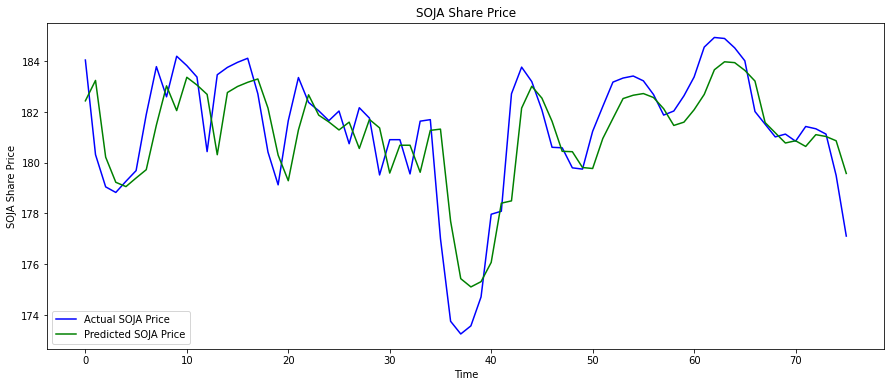

In [27]:
plotGraph(actual_prices,predicted_prices)

In [24]:
def predictTomorrow(real_data):
  prediction = model.predict(real_data)
  #transformar valores de 0 a 1 para os valores reais
  prediction = scaler.inverse_transform(prediction)
  return prediction

In [25]:
#Predict Next Day
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs+prediction_days), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = predictTomorrow(real_data)

print(f"Prediction: {prediction}")
print(f"Date prediction: ",data["date"].iloc[-1])
print(f"Last price",scaler.inverse_transform(x_test[-1]))
print(f"Date last price: ",data["date"].iloc[-2])



1/1 [==============================] - 0s 17ms/step
Prediction: [[177.76877]]
Date prediction:  01/12/2022
Last price [[179.5]]
Date last price:  30/11/2022
